In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [167]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['nback'])
print(len(subs))

X = get_X(allts, ['nback'], subs)
print(X[0].shape)

905
(905, 264, 231)


In [168]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.corrcoef(ts) for ts in filter_design_ts(X[0])]
p = np.stack(p)
print(p.shape)

(905, 264, 264)


/tmp/ipykernel_9999/2331917358.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


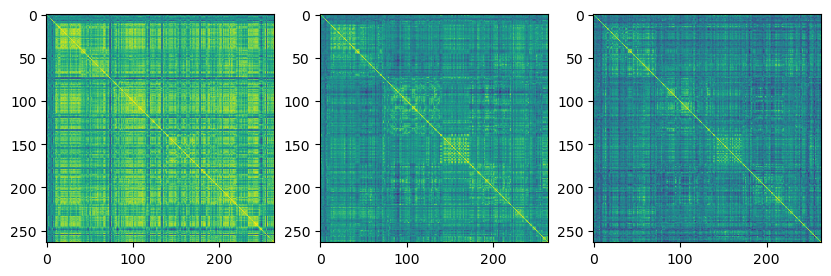

In [169]:
# Check pearson matrices

import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(p[10])
ax[1].imshow(p[60])
ax[2].imshow(p[100])
fig.show()

In [218]:

import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

# outliers = np.array([167, 405, 58, 129, 602])
outliers = np.array([141,429])
admit = np.setdiff1d(np.arange(p.shape[0]), outliers)
x = torch.from_numpy(p[admit]).float().cuda()
xtr = x[:600]
xt = x[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y[admit]).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

xtr = torch.stack([mask(xtr[i]) for i in range(xtr.shape[0])])

class LowRankCodes(nn.Module):
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.book = []
        for rank in ranks:
            self.book.append(nn.Parameter(1e-5*torch.randn(rank,264).float().cuda()))
        self.book = nn.ParameterList(self.book)
        
    def forward(self):
        book = []
        for page in self.book:
            book.append(mask(page.T@page))
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    def __init__(self, nsubs, nranks):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(torch.ones(nsubs, nranks).float().cuda())
        
    def forward(self, book):
        return torch.einsum('nr,rab->nab',self.w,book)
    
class LowRankEstimator(nn.Module):
    def __init__(self, nranks):
        super(LowRankEstimator, self).__init__()
        self.l1 = nn.Linear(nranks, 10).float().cuda()
        self.l2 = nn.Linear(10, 1).float().cuda()
        
    def forward(self, w):
        y = F.relu(self.l1(w))
        y = self.l2(y)
        return y.squeeze()
    
nEpochs = 4000
pPeriod = 400

mseLoss = nn.MSELoss()
    
lrc = LowRankCodes(10*[1])
lrw = LowRankWeights(xtr.shape[0], 10)
lre = LowRankEstimator(10)

optim = torch.optim.Adam(
    [
        {'params': itertools.chain(lrc.parameters(), lrw.parameters())}, 
        {'params': lre.parameters(), 'lr': 1e-2, 'weight_decay': 1e-3}
    ], 
    lr=1e-2, 
    weight_decay=0
)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)
    
for epoch in range(nEpochs):
    optim.zero_grad()
    book = lrc()
    xhat = lrw(book)
    yhat = lre(lrw.w)
    xloss = mseLoss(xhat, xtr)
    yloss = 1e-1*mseLoss(yhat, ytr)**0.5
    (xloss+yloss).backward()
    optim.step()
    sched.step(xloss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(xloss)} {float(yloss)} lr: {sched._last_lr}')
        
print('Complete')

0 0.14520451426506042 18.294981002807617 lr: [0.01, 0.01]
400 0.051386259496212006 0.008663798682391644 lr: [0.0019371148445850085, 0.0019371148445850085]
800 0.05105719342827797 0.0006560611072927713 lr: [0.0003056364591332405, 0.0003056364591332405]
1200 0.05099779739975929 6.294667400652543e-05 lr: [4.581192650606181e-05, 4.581192650606181e-05]
1600 0.050986163318157196 2.4069218852673657e-05 lr: [7.228169792062385e-06, 7.228169792062385e-06]


KeyboardInterrupt: 

In [214]:
print(lrw.w[0:5,0:5])
print(lre.l1.weight[0])

tensor([[1.6551, 1.6600, 1.6688, 1.6111, 1.4987],
        [2.5765, 2.5787, 2.5802, 2.5190, 2.4192],
        [1.3560, 1.3622, 1.3850, 1.3070, 1.2177],
        [2.8565, 2.8586, 2.8683, 2.8073, 2.6866],
        [1.2030, 1.2059, 1.2159, 1.1554, 1.0575]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([1.1900, 0.8736, 1.2163, 1.1046, 1.1885, 1.0558, 1.0486, 0.9692, 1.1387,
        1.0645, 0.9266, 0.9580, 0.9054, 1.2199, 0.8854, 0.9421, 1.1739, 1.2595,
        1.1932, 0.9737], device='cuda:0', grad_fn=<SelectBackward0>)


In [216]:
# Estimate test set

xt = torch.stack([mask(xt[i]) for i in range(xt.shape[0])])

lrw2 = LowRankWeights(xt.shape[0], 20)

optim = torch.optim.Adam(
    itertools.chain(lrw2.parameters()), 
    lr=1e-1, 
    weight_decay=0
)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

with torch.no_grad():
    book = lrc()
    
nEpochs = 500

for epoch in range(nEpochs):
    optim.zero_grad()
    xhat2 = lrw2(book)
    loss = mseLoss(xhat2, xt)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)} lr: {sched._last_lr}')
    
print(float(loss))

0 0.05599358677864075 lr: [0.1]
400 0.02483372762799263 lr: [0.025034408974245494]
499 0.02483372762799263 lr: [0.015777921478822676]
0.02483372762799263


In [217]:
xxtr = lrw.w.detach().clone()
xxt = lrw2.w.detach().clone()

w, _, _, _ = torch.linalg.lstsq(xxtr, ytr)

print(mseLoss(xxtr@w, ytr)**0.5)
print(mseLoss(xxt@w, yt)**0.5)

print(xxtr.shape)

tensor(0.0336, device='cuda:0')
tensor(56.0538, device='cuda:0')
torch.Size([600, 20])


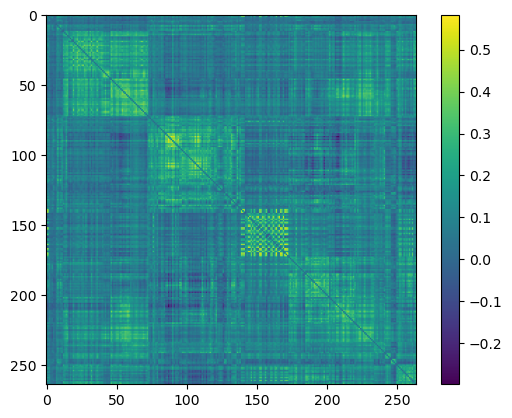

In [184]:
plt.imshow(xhat2[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

[172 261 136 264 173]
[169  70  38 179 145]
[159 292 165  19   2]
[181  15 157 153 177]
[47.88779068 47.97554016 49.60323715 50.29970551 53.65899277]


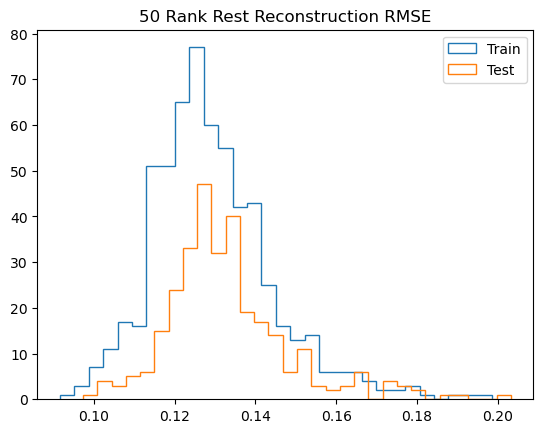

In [185]:
err = np.array([float(torch.dist(xtr[i], xhat[i])) for i in range(xhat.shape[0])])
err2 = np.array([float(torch.dist(xt[i], xhat2[i])) for i in range(xhat2.shape[0])])

idcs = np.argsort(err2)
print(idcs[:5])
print(idcs[20:25])
print(idcs[100:105])
print(idcs[-5:])
print(err2[idcs[-5:]])

plt.hist((err**2/264/264)**0.5, bins=30, histtype='step', label='Train')
plt.hist((err2**2/264/264)**0.5, bins=30, histtype='step', label='Test')
plt.title('50 Rank Rest Reconstruction RMSE')
plt.legend()
plt.show()

In [1]:
# Try predict ages

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y[admit]).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(y[:10])
print(y_t.shape)

# xxtr = lrw.w.detach().clone()
# xxt = lrw2.w.detach().clone()
xx = lrw.w.detach().clone()
xxtr = xx[:600]
xxt = xx[600:]

w, _, _, _ = torch.linalg.lstsq(xxtr, ytr)

print(mseLoss(xxtr@w, ytr)**0.5)
print(mseLoss(xxt@w, yt)**0.5)

print(xxtr.shape)

NameError: name 'get_y' is not defined